In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import pandahouse as ph

sns.set(font_scale=1.2,
        style='whitegrid')

# Вариант 2

*Функции, которые необходимо написать для решения задачи 3, будут написаны в ходе решения задачи 1*

Итак, начнем с загрузки данных. Грузим данные об активных пользователях и об оплате. Проверяем на пропущенные данные и типы.

In [4]:
active = pd.read_csv('active_studs.csv')
checks = pd.read_csv('checks.csv', sep=';') 

In [5]:
active.isna().sum()

student_id    0
dtype: int64

In [6]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [7]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [8]:
active.dtypes

student_id    int64
dtype: object

###### 1. Далее будем грузить данные о группах пользователях.
**Попутно решаем задачу 3.** Будем подготавливать данные к анализу.
В фрейме df содержатся данные о разбиении на группы. 

Функция **load_data** будет 
 - загружать данные из файла filename
 - сливать новые данные с исходным датафреймом df (если он дан)

In [9]:
def load_data(filename, df=pd.DataFrame(), sep=','):
    try:
        # мучаемся с разделителями
        df_loaded = pd.read_csv(filename, sep=sep)
        if (df_loaded.shape[1] != 2):
            df_loaded = pd.read_csv(filename, sep=';')
        # если ничего не получилось, не угадали разделитель    
        if (df_loaded.shape[1] != 2):
            print('specify the separator')
            return df
        # а если получилось, то соединяем датафреймы
        df_loaded = df_loaded.dropna()
        df_loaded = df_loaded.rename(columns={'id': 'student_id'})
        return pd.concat([df, df_loaded], ignore_index=True)
    except FileNotFoundError: 
        print('failed to load data')
        return df

Грузим данные о группах из 'groups.csv'. Получаем следующую выборку.

In [10]:
data = load_data('groups.csv')

In [11]:
data

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


Следующие две функции будут использоваться для выделения подгрупп активных пользователей и клиентов

In [12]:
def get_active(df):
    return df.loc[df.student_id.isin(active.student_id)]    

In [13]:
def get_customers(df):
    return df.merge(checks, on='student_id')

###### 2. Визуализируем данные

Функция **get_graph** будет рисовать boxplot и гистограмму для обеих групп (конечно для тех пользователей, что произвели оплату)

In [14]:
def get_graph(df):
    dt = get_customers(df)
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))
    sns.boxplot(data=dt, x='rev', y='grp', ax=axes[0])
    axes[0].set(title="Распределение оплаты по группам\n",
                xlabel='',
                ylabel='Группа')

    ax2 = sns.histplot(data=dt, x='rev', hue='grp', kde=True, bins=30, ax=axes[1])
    ax2.set(title="Гистограмма по группам\n",
            xlabel='Оплата',
            ylabel='Количество')

    sns.despine()

Посмотрим, что нам покажет визуализация исходных данные, исходя из нее, примем решения о метриках, которые будем рассматривать.

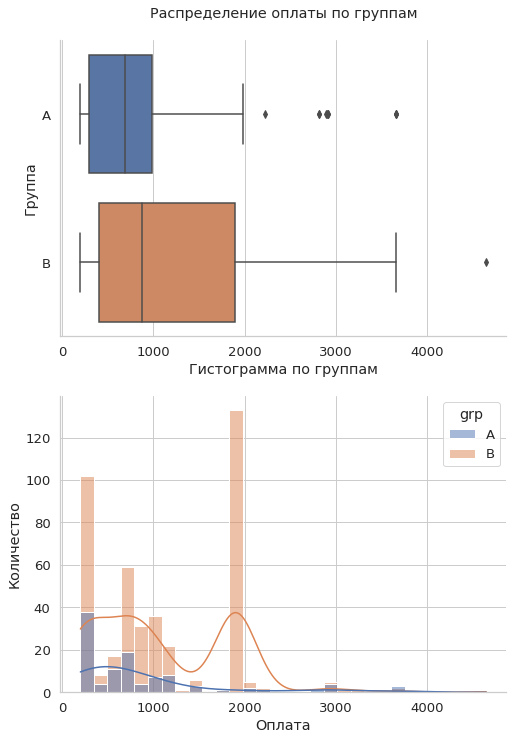

In [15]:
get_graph(data)

На первый взгляд дела в тестовой группе (B) обстоят гораздо лучше. Еще явно видно, что размер оплаты концентрируется на определенных суммах. Откуда можно сделать предположение, что существет некоторая абонентская плата (на которой достигается мода), а остальное - это какие-то дополнительные покупки в приложении. Судя по тому, что в контрольной группе мода сместилась, то можно сделать предположение, что тестировался переход на новый тарифный план (с 290 на 1900), что весьма существенный рост, поэтому имеет смысл следить за тем, какая доля клиентов оплатила сумму равную моде в соответствующих группах.

В связи с существенным ростом оплаты, нужно также контролировать степень удовлетворенности пользователей, поэтому будем смотреть на конверсию из пользователей в клиенты.

Еще видно, что в группах есть выбросы, поэтому сравнение медиан будет лучше сравнения средних (а медиана в тестовой больше, см boxplot)

Выборки не нормальны (логарифмирование и вообще применение любой монотонной функции тут не поможет), поэтому если сравнивать их, то применять или бутстреп для оценки параметров или критерий Манна-Уитни.

Однако отметим, что размеры групп разные, поэтому для сравнения нужны относительные метрики.  
Нам неизвестны расходы, которые были при проведении данного сеста, но нам нужно убедиться, что и относительные доходы (arppu, arpu) тоже увеличились.

In [16]:
data.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

Кроме того, количество клиентов оказывается больше количества активных клиентов. 
Непонятно из задачи, баг это или фича, потому что если у нас какое-то приложение, а покупки можно сделать только в нем, 
то мы пропускаем активных клиентов (баг) во время A\B теста, а если у нас какой-нибудь стим, где что-то накупили на распродаже 
и не пользовались этим, то все нормально.

Будем считать это фичей и поэтому отдельно придется рассматривать конверсию из пользователей в клиенты. Последнее более важно, поэтому везде далее мы рассматриваем именно всех клиентов.

In [17]:
# клиенты, сделавшие оплату
get_customers(data).shape[0]

540

In [18]:
# активные клиенты, сделавшие оплату
get_customers(get_active(data)).shape[0]

391

##### 3. Определимся с метриками, которые будем отслеживать для групп
1. Группа статистических метрик
   - Среднее выборочное(**с_mean**)
   - Медиана для оплаты (**с_med**)
   - мода (**с_mode**)
   - доля количества пользователей, которые оплатили сумму, равную моде (**modeA_ratio**, **modeB_ratio**)

2. Метрики, связанные с заинтересованностью пользователей
   - конверсия в активные (**cr_active**)
   - конверсия из активных в оплату (**cr_custom**)
   - конверсия в оплату (**cr_pay**)

3. Метрики, связванные с доходом
   - ARPPU средний доход на клиента (**arppu**) 
   - ARPU средний доход на пользователя (**arpu**)
   
   
Функция **get_metrics** вычисляет вышеперечисленные метрики


In [19]:
# Для автоматизации, считает количество элементов в группах, сливает с df_res
def get_count(df, col_name, df_res=pd.DataFrame(data=['A', 'B'], columns=['grp'])):
    res = df.groupby('grp', as_index=False)\
        .agg({'student_id': 'count'})\
        .rename(columns={'student_id': col_name})\
        .astype({col_name: 'int32'})
    return df_res.merge(res, how='left', on='grp').fillna(0)

In [20]:
get_count(data, col_name='group_size')

,grp,group_size
0,A,14671
1,B,59813


In [21]:
def get_stat(df, metrics):
    ''''добавляет в metrics сумму, среднее, медиану и моду данных из df, сгруппированных по группе'''
    res = df.groupby('grp', as_index=False)\
        .agg(c_sum=('rev', 'sum'),
             c_mean=('rev', 'mean'),
             c_med=('rev', np.median),
             c_mode=('rev', lambda x: ss.mode(x)[0][0]))
    return metrics.merge(res, on='grp')

In [22]:
col_list = ['grp', 'group_size', 'customers', 'c_mean', 'c_med', 'c_mode', 'modeA_ratio', 
            'modeB_ratio', 'cr_active', 'cr_custom', 'cr_pay', 'arppu', 'arpu']

In [23]:
def get_metrics(data):
    # размер группы
    metrics = get_count(data, 'group_size')
    # число активных пользователей
    metrics = get_count(get_active(data), 'active', metrics)
    # число клиентов
    customers = get_customers(data)
    metrics = get_count(customers, 'customers', metrics)
    # число активных клиентов
    metrics = get_count(get_customers(get_active(data)), 'active_customers', metrics)
    # считаем статистику
    metrics = get_stat(customers, metrics)
    # считаем целевые метрики
    
    metrics = get_count(customers.loc[abs(metrics.loc[0, 'c_mode'] - customers.rev) < 0.1], 'modeA_count', metrics)
    metrics = get_count(customers.loc[abs(metrics.loc[1, 'c_mode'] - customers.rev) < 0.1], 'modeB_count', metrics)
    
    metrics = metrics.assign( 
        modeA_ratio=round(metrics.modeA_count / metrics.customers * 100, 2),
        modeB_ratio=round(metrics.modeB_count / metrics.customers * 100, 2),
        cr_active=round(metrics.active / metrics.group_size * 100, 2),
        cr_custom=round(metrics.customers / metrics.active * 100, 2),
        cr_pay=round(metrics.active_customers / metrics.group_size * 100, 2),
        arppu=round(metrics['c_sum'] / metrics.customers, 2),
        arpu=round(metrics['c_sum'] / metrics.group_size, 2))
       
    return metrics[col_list]

In [24]:
get_metrics(data)

,grp,group_size,customers,c_mean,c_med,c_mode,modeA_ratio,modeB_ratio,cr_active,cr_custom,cr_pay,arppu,arpu
0,A,14671,107,860.710280,690.0,290.0,28.97,0.00,10.46,6.97,0.53,860.71,6.28
1,B,59813,433,1106.997699,880.0,1900.0,14.55,30.48,11.36,6.37,0.52,1107.00,8.01


###### 4. Сравниваем тестовую и контрольную группу
Сначала применим критерий Манна-Уитни, будем проверять, что A "меньше" B


In [25]:
def check_diff(data):
    customers = get_customers(data)
    A = customers.query("grp == 'A'").rev.values
    B = customers.query("grp == 'B'").rev.values
    return ss.mannwhitneyu(A, B, alternative='less')

In [26]:
check_diff(data)

MannwhitneyuResult(statistic=17850.0, pvalue=0.00010509845166809122)

*p_value < 0.05*, поэтому мы можем принять гипотезу о том, что результаты тестовой выборки в целом лучше контрольной

А теперь проведем bootstrap для медиан (как указано выше, в выборках есть выбросы)

In [35]:
def get_bootstrap(control, test, bs_iternum=1000, bs_value=0.05, bs_stat=np.mean):

    bs_size1 = len(test)
    bs_size2 = len(control)
    # нагенерируем себе выборку с повторениями и посчитаем разницу статистик для них, положим в массив
    bs_data = []
    for i in range(bs_iternum):
        sample_1 = np.random.choice(test, bs_size1, replace=True)
        sample_2 = np.random.choice(control, bs_size2, replace=True)
        bs_data.append(bs_stat(sample_1) - bs_stat(sample_2))
    # считаем p_value
    s_pos = np.sum([x > 0 for x in bs_data])
    s_neg = np.sum([x < 0 for x in bs_data])
    p_value = min(s_pos, s_neg) * 2 / bs_iternum 
    
    df_bs = pd.DataFrame(bs_data)
   
    # границы доверительного интервала
    left_q = bs_value / 2
    right_q = 1 - bs_value / 2
    quants = df_bs.quantile([left_q, right_q])
    
    # Визуализация
    _, _, bars = plt.hist(df_bs[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    
    return {"quants": quants, 
            "p_value": p_value}

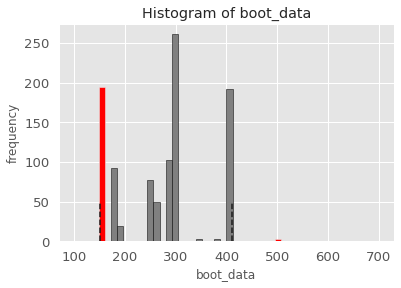

{'quants':            0
 0.025  150.0
 0.975  410.0,
 'p_value': 0.0}

In [36]:
customers = get_customers(data)
A = customers.query("grp == 'A'").rev.values
B = customers.query("grp == 'B'").rev.values
get_bootstrap(A, B, bs_iternum=1000, bs_stat=np.median)

0 не лежит в доверительном интервале, поэтому можно  с 95% уверенностью можно считать, что медиана тестовой выборки больше медианы контрольной

##### 5. Возьмем новые данные и сделаем то же самое


In [33]:
new_data = load_data('group_add.csv', data)

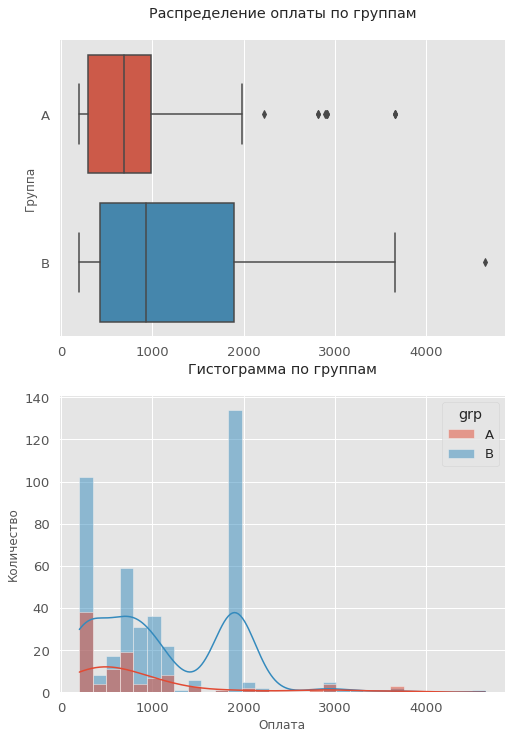

In [34]:
get_graph(new_data)

In [35]:
get_metrics(new_data)

,grp,group_size,customers,c_mean,c_med,c_mode,modeA_ratio,modeB_ratio,cr_active,cr_custom,cr_pay,arppu,arpu
0,A,14693,107,860.710280,690.0,290.0,28.97,0.00,10.47,6.96,0.53,860.71,6.27
1,B,59883,434,1108.824893,935.0,1900.0,14.52,30.65,11.36,6.38,0.52,1108.82,8.04


In [36]:
check_diff(new_data)

MannwhitneyuResult(statistic=17862.0, pvalue=9.658027498190076e-05)

##### 5. Подведем итог.
Исходя из полученных данных можно сделать следующие выводы
- в данных есть ярко выраженные всплески, предполагаемые "тарифные планы", в качестве теста по-видимому было введение нового тарифного плана в 1900, в контрольной группе этот план был недоступен, в тестовой на него подписалось 30% пользователей, на самом популярном старом осталось 15%. В контрольной группе на старом было 28%. Введение тового "тарифного плана" повысило средний доход (arpu, arppu) в тестовой группе. При этом мы видим небольшое (менее 1%) падение конверсии из активных пользователей в клиенты и незначительное (<0.02%) падение конверсии в клиенты из пользователей при увеличении доли активных пользователей на 1%
- выборочное среднее и медиана при этом статистически значимо (на уровне 95%) увеличились в тестовой группе, что было проверено критерием Манна-Уитни и построением доверительного интервала бутстрепом.
- при появлении новых данных мы получили картину, аналогичную исходным данным.


Считаю, что новую механику можно запустить на всех пользователей

##### 6. Запросы SQL
###### 1. Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов. Под очень усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

~~~ SQL
SELECT COUNT(*)
FROM
    (SELECT SUM(correct) as solved_problems
    FROM peas
    GROUP BY  st_id
    HAVING solved_problems >= 20
    )
    
~~~

Данные только за 2 дня в октябре, поэтому условие "рещить за текущий месяц" здесь избыточно.

Выполним запрос.



In [2]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database': 'default',
                      'user': 'student', 
                      'password': 'dpo_python_2020'}

In [43]:
query1 = """
SELECT COUNT(*) as hard_students 
FROM
    (SELECT SUM(correct) as solved_problems
    FROM peas
    GROUP BY  st_id
    HAVING solved_problems >= 20
    )
"""
df1 = ph.read_clickhouse(query1, connection=connection_default)
df1

,hard_students
0,136


###### 2. Необходимо в *одном запросе* выгрузить следующую информацию о группах пользователей:
- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

~~~ SQL
SELECT 
    info.group as group, 
    /*ARPPU = доход делим на число пользователей (различных)*/
    SUM(info.total_money) / COUNT (DISTINCT info.st_id) as ARPU,
    /*ARPAU = доход делим на число активных*/
    SUM (IF (info.solved_problems > 10, info.total_money, 0)) / SUM (IF (info.solved_problems > 10, 1, 0)) as ARPAU,
    /*CR в оплату*/
    SUM (IF (info.total_money > 0, 1, 0)) / COUNT (DISTINCT info.st_id) * 100 as CR_pay,
    /*CR активного в покупку*/
    SUM (IF (info.total_money > 0 
            AND info. solved_problems > 10,
            1,0)
        ) /
    SUM (IF (info.solved_problems > 10, 1, 0)) * 100 as CR_active_pay,
    /*CR из активного по математике в покупку*/
    SUM( IF(info.math_money > 0
        AND info.solved_math >= 2,
        1, 0)
        ) /
    SUM (IF (info.solved_math >= 2, 1, 0)) * 100 as CR_active_math    

FROM
/*Таблица с информацией о группе, решенных задача и об оплате*/
(SELECT
    group_problems.st_id as st_id,
    group_problems.group as group,
    group_problems.solved_problems as solved_problems,
    group_problems.solved_math as solved_math,
    check.total_money  as total_money,
    check.math_money as math_money
FROM
    /*Группу присрединим к информации о решенных задачах*/
    (SELECT 
        studs.st_id as st_id,
        studs.test_grp  as group,
        problems_table.solved_problems as solved_problems,
        problems_table.solved_math as solved_math
        
    FROM studs
    LEFT JOIN 
        /* Соберем информацию о количестве решенных задач и 
        решенных задач по математике */ 
        (SELECT 
            st_id,
            SUM( correct ) as solved_problems,
            SUM( IF(  subject = 'Math' AND correct, 1, 0)) as solved_math
        FROM peas
        GROUP BY st_id
        ) as problems_table
    ON studs.st_id = problems_table.st_id
    ) as group_problems
LEFT JOIN
    (SELECT
        st_id,
        /* все оплата */
        SUM( check.money ) as total_money,
        /*оплата мат курса*/
        SUM( IF( check.subject = 'Math', check.money, 0)) as math_money
    FROM
        final_project_check as check
    GROUP BY st_id
    ) as check
ON group_problems.st_id = check.st_id
) as info


GROUP BY info.group
~~~

In [3]:
query2 = """
SELECT 
    info.group as group, 
    /*ARPPU = доход делим на число пользователей (различных)*/
    SUM(info.total_money) / COUNT (DISTINCT info.st_id) as ARPU,
    /*ARPAU = доход делим на число активных*/
    SUM (IF (info.solved_problems > 10, info.total_money, 0)) / SUM (IF (info.solved_problems > 10, 1, 0)) as ARPAU,
    /*CR в оплату*/
    SUM (IF (info.total_money > 0, 1, 0)) / COUNT (DISTINCT info.st_id) * 100 as CR_pay,
    /*CR активного в покупку*/
    SUM (IF (info.total_money > 0 
            AND info. solved_problems > 10,
            1,0)
        ) /
    SUM (IF (info.solved_problems > 10, 1, 0)) * 100 as CR_active_pay,
    /*CR из активного по маткматике в покупку*/
    SUM( IF(info.math_money > 0
        AND info.solved_math >= 2,
        1, 0)
        ) /
    SUM (IF (info.solved_math >= 2, 1, 0)) * 100 as CR_active_math    

FROM
/*Таблица с информацией о группе, решенных задача и об оплате*/
(SELECT
    group_problems.st_id as st_id,
    group_problems.group as group,
    group_problems.solved_problems as solved_problems,
    group_problems.solved_math as solved_math,
    check.total_money  as total_money,
    check.math_money as math_money
FROM
    /*Группу присрединим к информации о решенных задачах*/
    (SELECT 
        studs.st_id as st_id,
        studs.test_grp  as group,
        problems_table.solved_problems as solved_problems,
        problems_table.solved_math as solved_math
        
    FROM studs
    LEFT JOIN 
        /* Соберем информацию о количестве решенных задач и 
        решенных задач по математике */ 
        (SELECT 
            st_id,
            SUM( correct ) as solved_problems,
            SUM( IF(  subject = 'Math' AND correct, 1, 0)) as solved_math
        FROM peas
        GROUP BY st_id
        ) as problems_table
    ON studs.st_id = problems_table.st_id
    ) as group_problems
LEFT JOIN
    (SELECT
        st_id,
        /* все оплата */
        SUM( check.money ) as total_money,
        /*оплата мат курса*/
        SUM( IF( check.subject = 'Math', check.money, 0)) as math_money
    FROM
        final_project_check as check
    GROUP BY st_id
    ) as check
ON group_problems.st_id = check.st_id
) as info


GROUP BY info.group
"""
df2 = ph.read_clickhouse(query2, connection=connection_default)
df2.round(2)

,group,ARPU,ARPAU,CR_pay,CR_active_pay,CR_active_math
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52
